## 历史以及基操
正则表达式 -> 上下文无关语法  -> 统计学派+规则学派 -> 隐马尔可夫  -> 循环神经网络  -> 深度学习有效性  -> Word2Vec（词向量）

### 歧义

- 词法分析歧义、语法分析歧义、语义分析歧义、NLP实际应用歧义（如语音识别）     
口语处理、分词处理、新词语产生、上下文知识、实体词   
***
- 1.词汇表， 字符表
- 2.句子或词语概率分布等级并由此引出字后面某字的概率（贝叶斯链式法则）

### 语言模型

- 一阶马尔科夫模型（当前随机变量取值只与上一时刻有关）
    - 句子中某个字只与前面一个字或词有关
- 二阶马尔科夫模型（当前随机变量取值只与上两时刻有关）
    - 句子中某个字只与前面2个字或词有关
- 可变长序列（句子长度是随机），定义停止状态符号和开始状态符号
- 三元语言模型 (N^3)   

```
句子： **我是中国人<s>
模型： p(我是中国人<s>)=q(我|*，*)q(是|我，*)...q(<s>|国，人)
```

- 极大似然估计 
```
参数： q(w|u,v)                  
MLE: q(w|u,v) = Count(w,u,v) / Count(u,v) -> q(人|国,中) = Count(中,国,人) / Count(国,人)   
```
- EM算法  
```
```
- 语言模型评价：迷惑度      
    - 测试集： m个句子$s_1,s_2,...,s_m$             
    - log概率：    大
        $$log \prod_{i=0}^mp(s_i) = \sum_{i=1}^mlog(p(s_i))$$           
    - perplexity： 小
        $$Perplexity = 2^{-l}$$   
        $$l = \frac{1}{M}\sum_{i=1}^mlog(p(s_i)),M是测试集总词量$$ 

***
- 稀疏性问题（语料库有限，语料库不存在某个词而导致实体词等被划分）    
    - 线性插值平滑
        - 高元n-gram模型没有足够数据时，改用低元n-gram模型进行概率估计         
        $$\hat{q}(w|u,v) = \lambda_3q(w|u,v) + \lambda_2q(w|u) + \lambda_1q(w)$$
        $$sum_i\lambda_i = 1$$           
        - hold-out数据交叉检验
    - 拉普拉斯平滑
        $$q(w|u) = \frac{c(w|u)+1}{c(w)+L}$$(L是所有训练集biggram的个数)
    
-  解码问题
    - 动态规划（?）
    
    - Viterbi算法
   ![avatar](../Img/viterbi.png)
   ![avatar](../Img/viterbi_show.png)

***
- 隐马尔卡夫模型HMM ---> 序列到序列的问题
    - 词性标注        
     ```
     in: 我是中国人       
     out: 我/n是/v中国人/n 
     ```
    - 命名实体识别(NER)          
    ```
    in: 大摩维持阿里巴巴的增持评级               
    out: 大摩/[Company]维持阿里巴巴/[Company]的增持评级
    ```
    - 模型参数        (参数数量： $M^2$ + $NM$)       
    $$词性序列二元马尔科夫链：q(s|u) (s\in S \bigcup \{<S>\}, u\in S \bigcup \{*\})---> M^2$$      
    $$词性与词语条件概率：e(x|s) (s\in S, x\in V) ---> NM$$  

### 神经语言模型 -词向量
参看论文：[A Neural Probabilistic Language Model, Yoshua Bengio,etc](https://wenku.baidu.com/view/82925cbba76e58fafbb0030a.html)        
解释文章：[A Neural Probabilistic Language Model 论文阅读及实战](https://www.jianshu.com/p/be242ed3f314)      
![avatar](../Img/NLM.png)

### 递归神经网络 RNN
参看论文： [Bidirection LSTM-CRF Models for Sequence Tagging, Zhiheng Huang, etc](https://www.docin.com/p-1652883441.html)       
解释文章： [【论文学习】Bidirectional LSTM-CRF Models for Sequence Tagging（论文翻译）](https://blog.csdn.net/Elvira521yan/article/details/88415512)              
![avatar](../Img/LSTM.png)

##  操作

In [2]:
import jieba
import re                                         # 寻找中文句子
import copy                                       # 类的复制
from sklearn.preprocessing import LabelEncoder    # 映射为整数
from collections import OrderedDict               # list of tuple 2 params 转为 字典
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt                    
import seaborn as sns
%matplotlib inline

In [3]:
with open('../Data/DRM.txt','rb')as f:
    print(f.read().decode('utf-8')[:300])

《红楼梦》曹雪芹

严正声明：本书为丫丫小说网(www.shuyaya.com)的用户上传至其在本站的存储空间，本站只提供TXT全集电子书存储服务以及免费下载服务，以下作品内容之版权与本站无任何关系。
在线阅读：http://www.shuyaya.com/read/2034/
--------------------------------------------------

第一回  甄士隐梦幻识通灵　贾雨村风尘怀闺秀

    		

    此开卷第一回也．作者自云：因曾历过一番梦幻之后，故将真事隐去，而借"通灵"之说，撰此《石头记》一书也．故曰"甄士隐"云云．但


### 分句

In [66]:
# 断句
lst_sectences = []                                                   # 文章划分为句子的列表
# str_puntCode = '.!?~． 。！？～\n'                                   # 句子终结符号串，判断句子是否结束
str_puntCode = "。！？!?\n\r"
start,i  = 0, 1

with open('../Data/DRM.txt','rb')as f:
    str_Text = f.read().decode('utf-8')
    str_Text += 's'
    assert type(str_Text)==str, "'str_Text' is not string"      # 检查正文读取的格式
    for i in range(len(str_Text)-1):
        # 句子结束
        if str_Text[i] in str_puntCode and str_Text[i+1] not in str_puntCode:
            lst_sectences.append(str_Text[start:i+1].strip())
            start = i+1                                                  # 开始指针指向结束符后，新起一句
            i += 1
        # 有内容
        else:
            i += 1
            
lst_sectences[:5]

['《红楼梦》曹雪芹',
 '严正声明：本书为丫丫小说网(www.shuyaya.com)的用户上传至其在本站的存储空间，本站只提供TXT全集电子书存储服务以及免费下载服务，以下作品内容之版权与本站无任何关系。',
 '在线阅读：http://www.shuyaya.com/read/2034/',
 '--------------------------------------------------',
 '第一回  甄士隐梦幻识通灵\u3000贾雨村风尘怀闺秀']

In [70]:
# 只保留中文并存储到新文件中
filter_re = re.compile(u'[^\u4E00-\u9FA5]')            # 只保留中文

with open('../Data/cleaned_DRM.txt', 'w') as f:
    for s in lst_sectences:
        cleaned_s = filter_re.sub(r'', s)             # 裁剪中文句子s，不符合的部分设为空
        if len(cleaned_s) :                           # 空行直接删除
            f.write(cleaned_s+'\n')

In [73]:
# 检查实际文本
i = 0
with open('../Data/cleaned_DRM.txt', 'r') as f:
    for l in f:
        if i >5:  break
        print(l)
        i += 1

红楼梦曹雪芹

严正声明本书为丫丫小说网的用户上传至其在本站的存储空间本站只提供全集电子书存储服务以及免费下载服务以下作品内容之版权与本站无任何关系

在线阅读

第一回甄士隐梦幻识通灵贾雨村风尘怀闺秀

此开卷第一回也作者自云因曾历过一番梦幻之后故将真事隐去而借通灵之说撰此石头记一书也故曰甄士隐云云但书中所记何事何人

自又云今风尘碌碌一事无成忽念及当日所有之女子一一细考较去觉其行止见识皆出于我之上何我堂堂须眉诚不若彼裙钗哉



### jieba分词

In [4]:
lst_cleanedText = []
with open('../Data/cleaned_DRM.txt', 'r') as f:
    for l in f:
        lst_cleanedText.append(l.strip())                   # 去除行尾的空格换行符

lst_cleanedText[:10]

['红楼梦曹雪芹',
 '严正声明本书为丫丫小说网的用户上传至其在本站的存储空间本站只提供全集电子书存储服务以及免费下载服务以下作品内容之版权与本站无任何关系',
 '在线阅读',
 '第一回甄士隐梦幻识通灵贾雨村风尘怀闺秀',
 '此开卷第一回也作者自云因曾历过一番梦幻之后故将真事隐去而借通灵之说撰此石头记一书也故曰甄士隐云云但书中所记何事何人',
 '自又云今风尘碌碌一事无成忽念及当日所有之女子一一细考较去觉其行止见识皆出于我之上何我堂堂须眉诚不若彼裙钗哉',
 '实愧则有余悔又无益之大无可如何之日也',
 '当此则自欲将已往所赖天恩祖德锦衣纨绔之时饫甘餍肥之日背父兄教育之恩负师友规谈之德以至今日一技无成半生潦倒之罪编述一集以告天下人我之罪固不免然闺阁中本自历历有人万不可因我之不肖自护己短一并使其泯灭也虽今日之茅椽蓬牖瓦灶绳床其晨夕风露阶柳庭花亦未有妨我之襟怀笔墨者虽我未学下笔无文又何妨用假语村言敷演出一段故事来亦可使闺阁昭传复可悦世之目破人愁闷不亦宜乎',
 '故曰贾雨村云云',
 '此回中凡用梦用幻等字是提醒阅者眼目亦是此书立意本旨']

In [5]:
# jieba分词列表
lst_cutWrords = [list(jieba.cut(s)) for s in lst_cleanedText]

lst_cutWrords[:3]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 2.152 seconds.
Prefix dict has been built succesfully.


[['红楼梦', '曹雪芹'],
 ['严正声明',
  '本书',
  '为',
  '丫丫',
  '小说网',
  '的',
  '用户',
  '上传',
  '至',
  '其',
  '在',
  '本站',
  '的',
  '存储空间',
  '本站',
  '只',
  '提供',
  '全集',
  '电子书',
  '存储',
  '服务',
  '以及',
  '免费',
  '下载',
  '服务',
  '以下',
  '作品',
  '内容',
  '之',
  '版权',
  '与',
  '本站',
  '无',
  '任何',
  '关系'],
 ['在线', '阅读']]

### 语言模型展示
```python
test_lst_cutwords = [['红楼梦', '曹雪芹'],
                    ['严正声明','本书','为','丫丫','小说网','的','用户','上传','至','其','在','本站','的'],
                     ['在线', '阅读']]
```

#### ngram提取

In [6]:
# 提取句中n元词组成list(无前缀和后缀)
method_generateNgrams = lambda sentence, n : zip(*[sentence[i:] for i in range(n)])

# 检查方法效果
for bigram in method_generateNgrams(lst_cutWrords[10], 2):
    print (bigram)
for unigram in method_generateNgrams(lst_cutWrords[10], 1):
    print( unigram)
    


('列位', '看官')
('看官', '你')
('你', '道')
('道', '此书')
('此书', '从何而来')
('列位',)
('看官',)
('你',)
('道',)
('此书',)
('从何而来',)


In [32]:
def get_nGramsModel(list_cutWords, int_nGram):
    list__nGramsModel = []
    sec = []
    for sentece in list_cutWords:
        sec = []
        # 前缀加上n个起始符号
        for i in range(int_nGram-1):
            sec.append('*')
        sec.extend(sentece)
        # 后缀加上一个结束符号
        sec.append('#')
        
        sec = list(method_generateNgrams(sec, int_nGram))
        
        list__nGramsModel.append(sec)
    
    return list__nGramsModel

# test 'get_nGramsModel' method
test_lst_cutwords = [['红楼梦', '曹雪芹'],
                     ['在线', '阅读']]
print(get_nGramsModel(test_lst_cutwords, 3))

[[('*', '*', '红楼梦'), ('*', '红楼梦', '曹雪芹'), ('红楼梦', '曹雪芹', '#')], [('*', '*', '在线'), ('*', '在线', '阅读'), ('在线', '阅读', '#')]]


In [7]:
# 自定义方法，给n元及以上的模型句子加上n个起始符号、1个结束符号，并组成ngram模型
def ngrams_parameter_estimate(sentences, n):
    sentences_copy = copy.deepcopy(sentences)
    ngrams_dict = {}
    num_ngrams = 0
    for words in sentences_copy:
        # ngram 加上n个起始符号
        for i in range(n-1):
            words.insert(0, '*')
        words.append('#')
        ngrams = method_generateNgrams(words, n)                                    # 组成ngram
        for ngram in ngrams:
            ngrams_dict[ngram] = ngrams_dict.get(ngram, 0.0) + 1.0            # 没有‘ngram’项则初始化为0.0
            num_ngrams += 1                                                   # 统计ngram 对应数量

    return ngrams_dict, num_ngrams

In [8]:
# 计算ngram模型概率
def calculate_sentence_log_probability(sentence, n, num_grams, ngrams_dict, n_1grams_dict=None):
#     assert len(ngrams_dict.keys()[0]) == n, n
    if n_1grams_dict is None: assert n == 1
        
    ngrams = generate_ngrams(sentence, n)
    log_prob, has_unknown_ngram = 0.0, False
    for ngram in ngrams:
        if ngram in ngrams_dict:
            if n == 1:
                log_prob += np.log2(ngrams_dict[ngram]/num_grams)
            else:
                log_prob += np.log2(ngrams_dict[ngram]/n_1grams_dict[ngram[:n-1]])
        else:
            has_unknown_ngram = True
    return 0.0 if has_unknown_ngram else log_prob

##### unigram

In [9]:
dict_unigrams, n_unigrams = ngrams_parameter_estimate(lst_cutWrords, 1)              # 一元
print(list(dict_unigrams.keys())[:10])
print(n_unigrams)

[('红楼梦',), ('曹雪芹',), ('#',), ('严正声明',), ('本书',), ('为',), ('丫丫',), ('小说网',), ('的',), ('用户',)]
465936


In [10]:
# 去除词频小于10的单词，并排序（大到小）
lst_sortedUnigram = sorted([(v, k)  for k, v in dict_unigrams.items() if v>10], key = lambda t:t[0], reverse=True)
print(lst_sortedUnigram[:10])
dict_sortedUnigram = OrderedDict(lst_sortedUnigram)

[(19613.0, ('了',)), (15799.0, ('#',)), (14114.0, ('的',)), (7252.0, ('我',)), (6298.0, ('他',)), (6052.0, ('道',)), (5824.0, ('说',)), (5794.0, ('你',)), (5748.0, ('是',)), (5631.0, ('也',))]


##### bigram

In [11]:
dict_bigrams, n_bigrams = ngrams_parameter_estimate(lst_cutWrords, 2)              # 二元
print(list(dict_bigrams.keys())[:10])
print(n_bigrams)

[('*', '红楼梦'), ('红楼梦', '曹雪芹'), ('曹雪芹', '#'), ('*', '严正声明'), ('严正声明', '本书'), ('本书', '为'), ('为', '丫丫'), ('丫丫', '小说网'), ('小说网', '的'), ('的', '用户')]
465936


In [12]:
# 去除词频小于10的单词，并排序（大到小）
lst_sortedBigram = sorted([(v, k)  for k, v in dict_bigrams.items() if v>10], key = lambda t:t[0], reverse=True)
print(lst_sortedBigram[:10])
dict_sortedBigram = OrderedDict(lst_sortedBigram)

[(2444.0, ('了', '#')), (1616.0, ('笑', '道')), (1254.0, ('*', '宝玉')), (971.0, ('听', '了')), (929.0, ('呢', '#')), (821.0, ('的', '#')), (821.0, ('*', '说')), (775.0, ('去', '了')), (754.0, ('说', '着')), (675.0, ('道', '你'))]


##### trigram

In [16]:
dict_trigrams, n_trigrams = ngrams_parameter_estimate(lst_cutWrords, 3)              # 三元
print(list(dict_trigrams.keys())[:10])
print(n_trigrams)

[('*', '*', '红楼梦'), ('*', '红楼梦', '曹雪芹'), ('红楼梦', '曹雪芹', '#'), ('*', '*', '严正声明'), ('*', '严正声明', '本书'), ('严正声明', '本书', '为'), ('本书', '为', '丫丫'), ('为', '丫丫', '小说网'), ('丫丫', '小说网', '的'), ('小说网', '的', '用户')]
465936


In [17]:
# 去除词频小于10的单词，并排序（大到小）
lst_sortedTrigram = sorted([(v, k)  for k, v in dict_trigrams.items() if v>10], key = lambda t:t[0], reverse=True)
print(lst_sortedTrigram[:10])
dict_sortedTrigram = OrderedDict(lst_sortedTrigram)

[(1254.0, ('*', '*', '宝玉')), (821.0, ('*', '*', '说')), (631.0, ('*', '说', '着')), (406.0, ('*', '*', '凤姐')), (316.0, ('*', '*', '众人')), (316.0, ('*', '宝玉', '道')), (286.0, ('*', '*', '王夫人')), (282.0, ('*', '*', '贾母')), (271.0, ('*', '*', '我')), (247.0, ('去', '了', '#'))]


##### 三个不同模型的可视化

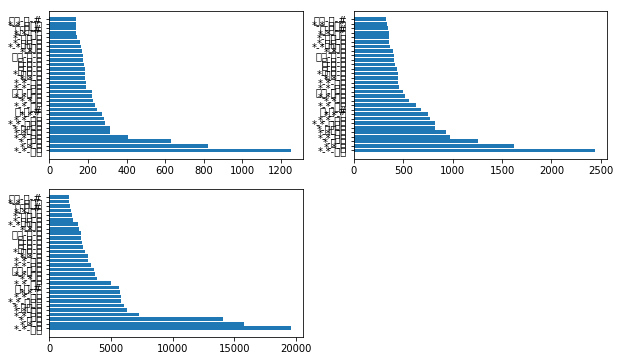

In [18]:
# encoding: utf-8
plt.figure(figsize=(10,6))

plt.subplot(221), plt.barh(['-'.join(t[1]) for t in lst_sortedTrigram[:30]], [t[0] for t in lst_sortedTrigram[:30]])
plt.subplot(222), plt.barh(['-'.join(t[1]) for t in lst_sortedTrigram[:30]], [t[0] for t in lst_sortedBigram[:30]])
plt.subplot(223), plt.barh(['-'.join(t[1]) for t in lst_sortedTrigram[:30]], [t[0] for t in lst_sortedUnigram[:30]])

plt.show()

Text(0, 0.5, 'frequency')

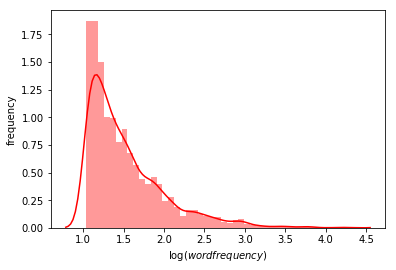

In [19]:
ax = sns.distplot(np.log10([t[0] for t in lst_sortedUnigram]), color='red')
ax.set_xlabel(r'$\log(word frequency)$')
ax.set_ylabel(r'frequency')

### 简单语言模型

#### 分割数据集

In [20]:
n_samples = len(lst_cutWrords)
n_valid = int(n_samples * 0.2)
n_test = int(n_samples * 0.3)

permutation = np.random.permutation(n_samples)                                      # 随机种子

array_shuffledSentences = np.array(lst_cutWrords)[permutation]                          # 矩阵化

train = array_shuffledSentences[:n_samples-n_test-n_valid]
valid = array_shuffledSentences[n_samples-n_test-n_valid:n_samples-n_test]
test = array_shuffledSentences[n_samples-n_test:]
len(train), len(valid), len(test)

(7901, 3159, 4739)

#### 训练模型（计算二元、三元模型计数字典）
$$p(sentece) = q(s_1|*,*) * q(s_2|s_1,*) * ... * q(<s>|s_{i-1}, s_i)$$
- $$q(w|u,v) = \frac{Count(w,u,v)}{Count(u,v)} = \frac{TriGram [s_i][0]}{biGram [s_i][0]}$$
$$l = \frac{1}{M}\sum_{i=1}^m{log (p(s_i))}, plexsity = 2^{-l}$$

##### 计算训练集二元模型
- 得到$q(w|u,v)$

In [21]:
dict_trainBigramdict,n_bigrams = ngrams_parameter_estimate(train, 2)
dict_trainTrigramdict,n_Trigrams = ngrams_parameter_estimate(train, 3)

##### 迷惑度（内含计算最大似然估计）
- 利用训练集的 $𝑞(𝑤|𝑢,𝑣)$ 计算测试集的 $p(sentece)$， 然后计算测试集$2^{-l}$

In [33]:
# 测试集组成二元、三元模型
lst_testTrigram = get_nGramsModel(test,3)                  # 三元模型，直接用于计算p
lst_testBigram = get_nGramsModel(test,2)                   # 二元模型，获得索引在计算

In [36]:
lst_testTrigram[1]

[('*', '*', '今日'),
 ('*', '今日', '天睁'),
 ('今日', '天睁', '了'),
 ('天睁', '了', '眼'),
 ('了', '眼', '把'),
 ('眼', '把', '这'),
 ('把', '这', '一个'),
 ('这', '一个', '祸害'),
 ('一个', '祸害', '妖精'),
 ('祸害', '妖精', '退送'),
 ('妖精', '退送', '了'),
 ('退送', '了', '大家'),
 ('了', '大家', '清净'),
 ('大家', '清净', '些'),
 ('清净', '些', '#')]

In [ ]:
def get_pSentece(n_model, d_trainTrigramdict, d_trainBigramdict):
    # 计算每个句子的p
    lst_testP = []
    int_product = 1
    ## 遍历列表内所有句子分组列表
    for trigrams in n_model:
        for tri in trigrams:
            str_biIndex = tri.pop(0)                                          # 获得用于biGrams索引的tuple
            p = d_trainTrigramdict[index] / d_trainBigramdict[index]
            int_product *= p                                                  # p连乘
        lst_testP.append(int_product)
        
# test 'get_pSentece' method
test_lst_cutwords = [['红楼梦', '曹雪芹'],
                     ['在线', '阅读']]
n_model = get_nGramsModel(test_lst_cutwords, 3)

print(get_pSentece(n_model))